In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Eingabeparameter ---
# Anlagenspezifisch
anlagenleistung_kwp = 10.0  # Installierte Leistung in kWp
investition_pro_kwp = 2500.0 # CHF pro kWp (Brutto-Investitionskosten)
foerderung_pro_kwp = 400.0   # CHF pro kWp (Einmalvergütung, Leistungsbeitrag <30kWp)
foerderung_max_anteil = 0.30 # Maximaler Förderanteil an Referenzkosten (angenommen Referenzkosten = Investitionskosten)

# Ertrags- und Verbrauchsdaten
jahresproduktion_kwh_pro_kwp = 1000.0 # kWh pro kWp pro Jahr
eigenverbrauchsquote = 0.70         # Anteil des produzierten Stroms, der selbst verbraucht wird (0.0 bis 1.0)
degradation_rate = 0.005            # Jährliche Degradation der Modulleistung (z.B. 0.005 für 0.5%)

# Kosten und Vergütungen (Jahr 1)
strompreis_bezug = 0.20             # CHF pro kWh (Preis für Strom aus dem Netz)
einspeiseverguetung = 0.06          # CHF pro kWh (Vergütung für eingespeisten Strom)
betriebskosten_faktor = 0.01        # Jährliche Betriebskosten als Anteil der Brutto-Investition (z.B. 0.01 für 1%)

# Wirtschaftliche Annahmen
strompreisentwicklung_pa = 0.01     # Jährliche Steigerung des Strompreises (z.B. 0.02 für 2%)
einspeiseverguetung_entwicklung_pa = 0.00 # Jährliche Änderung der Einspeisevergütung (z.B. 0.00 für konstant)
diskontsatz = 0.04                  # Kalkulatorischer Zinssatz für Barwertberechnung (z.B. 0.04 für 4%)

# Betrachtungszeitraum & Ökologie
lebensdauer = 25                    # Jahre
co2_grid_mix_g_kwh = 54.7           # g CO2eq/kWh für Schweizer Strommix (Lieferantenmix)

In [26]:
# Nettoinvestition
brutto_investition = anlagenleistung_kwp * investition_pro_kwp
max_foerderung = brutto_investition * foerderung_max_anteil
einmalverguetung = min(anlagenleistung_kwp * foerderung_pro_kwp, max_foerderung)
netto_investition = brutto_investition - einmalverguetung

# Jährliche Betriebskosten
betriebskosten_pa = brutto_investition * betriebskosten_faktor

# Initialisierung für jährliche Berechnungen
jahre = np.arange(1, lebensdauer + 1)
jaehrliche_produktion = np.zeros(lebensdauer)
jaehrliche_einsparung_bezug = np.zeros(lebensdauer)
jaehrliche_einnahme_einspeisung = np.zeros(lebensdauer)
jaehrliche_gesamteinsparung = np.zeros(lebensdauer)
jaehrlicher_cashflow = np.zeros(lebensdauer)
kumulierter_cashflow = np.zeros(lebensdauer)
barwert_cashflow = np.zeros(lebensdauer)
kumulierter_barwert_cashflow = np.zeros(lebensdauer)
aktueller_strompreis_bezug = strompreis_bezug
aktuelle_einspeiseverguetung = einspeiseverguetung

In [27]:
# Simulation über die Lebensdauer
for i in range(lebensdauer):
    jahr = i + 1

    # 1. Energieproduktion (mit Degradation ab Jahr 2)
    if jahr == 1:
        jaehrliche_produktion[i] = anlagenleistung_kwp * jahresproduktion_kwh_pro_kwp
    else:
        jaehrliche_produktion[i] = jaehrliche_produktion[i-1] * (1 - degradation_rate)

    # 2. Aufteilung Eigenverbrauch & Einspeisung
    strom_eigenverbrauch = jaehrliche_produktion[i] * eigenverbrauchsquote
    strom_einspeisung = jaehrliche_produktion[i] * (1 - eigenverbrauchsquote)

    # 3. Einsparung durch vermiedenen Strombezug (mit Preisentwicklung)
    jaehrliche_einsparung_bezug[i] = strom_eigenverbrauch * aktueller_strompreis_bezug

    # 4. Einnahmen durch Einspeisung (mit Preisentwicklung)
    jaehrliche_einnahme_einspeisung[i] = strom_einspeisung * aktuelle_einspeiseverguetung

    # 5. Gesamte jährliche Einnahmen/Einsparungen
    jaehrliche_gesamteinsparung[i] = jaehrliche_einsparung_bezug[i] + jaehrliche_einnahme_einspeisung[i]

    # 6. Jährlicher Cashflow (Einsparungen/Einnahmen - Betriebskosten)
    jaehrlicher_cashflow[i] = jaehrliche_gesamteinsparung[i] - betriebskosten_pa

    # 7. Kumulierter Cashflow (für einfache Amortisation)
    if i == 0:
        kumulierter_cashflow[i] = jaehrlicher_cashflow[i]
    else:
        kumulierter_cashflow[i] = kumulierter_cashflow[i-1] + jaehrlicher_cashflow[i]

    # 8. Barwert des Cashflows (für diskontierte Amortisation)
    barwert_cashflow[i] = jaehrlicher_cashflow[i] / ((1 + diskontsatz)**jahr)

    # 9. Kumulierter Barwert des Cashflows
    if i == 0:
        kumulierter_barwert_cashflow[i] = barwert_cashflow[i]
    else:
        kumulierter_barwert_cashflow[i] = kumulierter_barwert_cashflow[i-1] + barwert_cashflow[i]

    # 10. Preise für nächstes Jahr aktualisieren
    aktueller_strompreis_bezug *= (1 + strompreisentwicklung_pa)
    aktuelle_einspeiseverguetung *= (1 + einspeiseverguetung_entwicklung_pa)



In [28]:
# Amortisationszeiten finden
einfache_amortisationszeit = np.argmax(kumulierter_cashflow >= netto_investition) + 1 if any(kumulierter_cashflow >= netto_investition) else -1
diskontierte_amortisationszeit = np.argmax(kumulierter_barwert_cashflow >= netto_investition) + 1 if any(kumulierter_barwert_cashflow >= netto_investition) else -1

# Gesamte CO2-Einsparung
gesamte_produktion_lebensdauer = np.sum(jaehrliche_produktion)
co2_einsparung_total_tonnen = (gesamte_produktion_lebensdauer * co2_grid_mix_g_kwh) / 1000 / 1000 # Umrechnung g -> t

In [29]:
print("--- Ergebnisse der Amortisationsrechnung ---")
print(f"Anlagenleistung: {anlagenleistung_kwp:.1f} kWp")
print(f"Brutto-Investition: {brutto_investition:,.2f} CHF")
print(f"Einmalvergütung (geschätzt): {einmalverguetung:,.2f} CHF")
print(f"Netto-Investition: {netto_investition:,.2f} CHF\n")

print(f"Jährliche Produktion (Jahr 1): {jaehrliche_produktion[0]:,.0f} kWh")
print(f"Davon Eigenverbrauch (Jahr 1): {jaehrliche_produktion[0]*eigenverbrauchsquote:,.0f} kWh ({eigenverbrauchsquote*100:.0f}%)")
print(f"Davon Einspeisung (Jahr 1): {jaehrliche_produktion[0]*(1-eigenverbrauchsquote):,.0f} kWh\n")

print(f"Einsparung Strombezug (Jahr 1): {jaehrliche_einsparung_bezug[0]:,.2f} CHF")
print(f"Einnahmen Einspeisung (Jahr 1): {jaehrliche_einnahme_einspeisung[0]:,.2f} CHF")
print(f"Betriebskosten (pro Jahr): {betriebskosten_pa:,.2f} CHF")
print(f"Cashflow (Jahr 1): {jaehrlicher_cashflow[0]:,.2f} CHF\n")

print("--- Amortisationszeiten ---")
if einfache_amortisationszeit > 0:
    print(f"Einfache Amortisationszeit: {einfache_amortisationszeit} Jahre")
else:
    print("Einfache Amortisation innerhalb der Lebensdauer nicht erreicht.")

if diskontierte_amortisationszeit > 0:
    print(f"Diskontierte Amortisationszeit (bei {diskontsatz*100:.1f}% Diskontsatz): {diskontierte_amortisationszeit} Jahre")
else:
    print(f"Diskontierte Amortisation (bei {diskontsatz*100:.1f}%) innerhalb der Lebensdauer nicht erreicht.")

print("\n--- Ökonomische Perspektive (Gesamt) ---")
gesamter_cashflow = np.sum(jaehrlicher_cashflow)
gewinn_nach_lebensdauer = gesamter_cashflow - netto_investition
print(f"Gesamter Cashflow über {lebensdauer} Jahre: {gesamter_cashflow:,.2f} CHF")
print(f"Reingewinn nach {lebensdauer} Jahren (nicht diskontiert): {gewinn_nach_lebensdauer:,.2f} CHF")

gesamter_barwert_cashflow = np.sum(barwert_cashflow)
gewinn_barwert = gesamter_barwert_cashflow - netto_investition
print(f"Gesamter Barwert der Cashflows über {lebensdauer} Jahre: {gesamter_barwert_cashflow:,.2f} CHF")
print(f"Nettobarwert (Net Present Value, NPV) der Investition: {gewinn_barwert:,.2f} CHF")

print("\n--- Ökologische Perspektive ---")
print(f"Geschätzte gesamte CO2-Einsparung über {lebensdauer} Jahre: {co2_einsparung_total_tonnen:.1f} Tonnen CO2eq")
print(f"(Basierend auf Verdrängung von Strom aus dem Schweizer Liefermix mit {co2_grid_mix_g_kwh:.1f} g CO2eq/kWh)")

--- Ergebnisse der Amortisationsrechnung ---
Anlagenleistung: 10.0 kWp
Brutto-Investition: 25,000.00 CHF
Einmalvergütung (geschätzt): 4,000.00 CHF
Netto-Investition: 21,000.00 CHF

Jährliche Produktion (Jahr 1): 10,000 kWh
Davon Eigenverbrauch (Jahr 1): 7,000 kWh (70%)
Davon Einspeisung (Jahr 1): 3,000 kWh

Einsparung Strombezug (Jahr 1): 1,400.00 CHF
Einnahmen Einspeisung (Jahr 1): 180.00 CHF
Betriebskosten (pro Jahr): 250.00 CHF
Cashflow (Jahr 1): 1,330.00 CHF

--- Amortisationszeiten ---
Einfache Amortisationszeit: 16 Jahre
Diskontierte Amortisationszeit (bei 4.0% Diskontsatz): 24 Jahre

--- Ökonomische Perspektive (Gesamt) ---
Gesamter Cashflow über 25 Jahre: 35,150.16 CHF
Reingewinn nach 25 Jahren (nicht diskontiert): 14,150.16 CHF
Gesamter Barwert der Cashflows über 25 Jahre: 21,761.80 CHF
Nettobarwert (Net Present Value, NPV) der Investition: 761.80 CHF

--- Ökologische Perspektive ---
Geschätzte gesamte CO2-Einsparung über 25 Jahre: 12.9 Tonnen CO2eq
(Basierend auf Verdrängung 

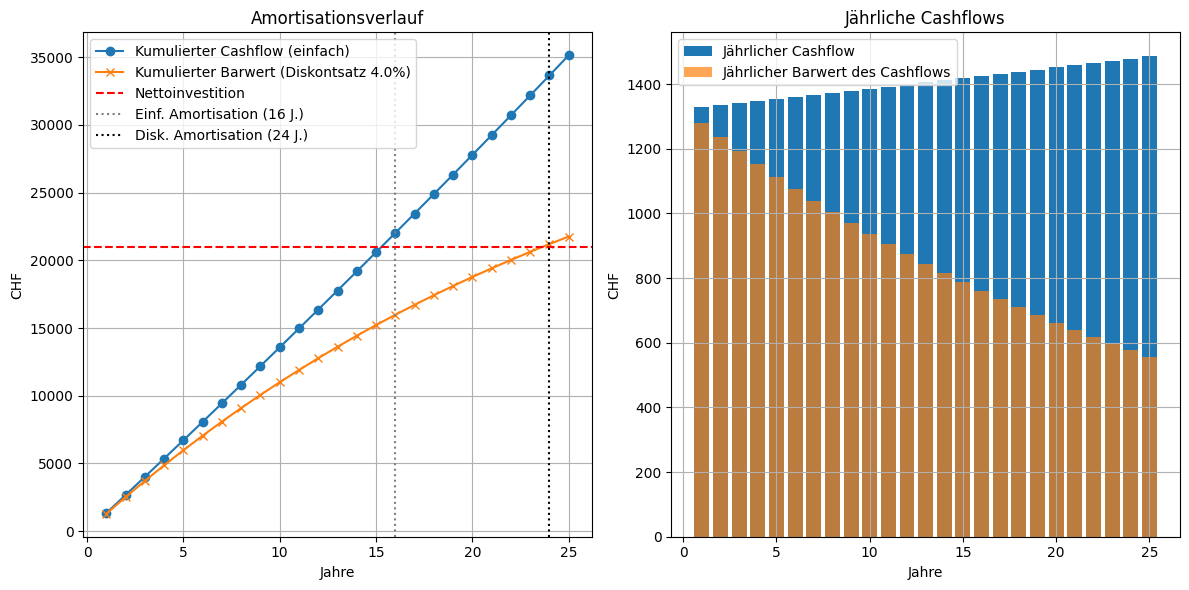

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(jahre, kumulierter_cashflow, label='Kumulierter Cashflow (einfach)', marker='o')
plt.plot(jahre, kumulierter_barwert_cashflow, label=f'Kumulierter Barwert (Diskontsatz {diskontsatz*100:.1f}%)', marker='x')
plt.axhline(netto_investition, color='red', linestyle='--', label='Nettoinvestition')
if einfache_amortisationszeit > 0:
    plt.axvline(einfache_amortisationszeit, color='gray', linestyle=':', label=f'Einf. Amortisation ({einfache_amortisationszeit} J.)')
if diskontierte_amortisationszeit > 0:
    plt.axvline(diskontierte_amortisationszeit, color='black', linestyle=':', label=f'Disk. Amortisation ({diskontierte_amortisationszeit} J.)')
plt.title('Amortisationsverlauf')
plt.xlabel('Jahre')
plt.ylabel('CHF')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(jahre, jaehrlicher_cashflow, label='Jährlicher Cashflow')
plt.bar(jahre, barwert_cashflow, label='Jährlicher Barwert des Cashflows', alpha=0.7)
plt.title('Jährliche Cashflows')
plt.xlabel('Jahre')
plt.ylabel('CHF')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()